In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, color, img_as_ubyte, morphology
from skimage.exposure import histogram
from skimage.filters import threshold_li
import cv2
from scipy import ndimage as ndi
from skimage import feature

def showImage(image):
    plt.figure(figsize=(100,100))
    plt.imshow(image, cmap="gray")
    plt.axis('off')
    plt.show()

path = 'images/'

image = io.imread(path + '002.jpg')
image_gray = color.rgb2gray(image)
print(image[1][1][0])

# showImage(image_gray)

print(image_gray[1][1])

im = image
im = cv2.resize(im,(362,512))

#showimg(im,title="Obraz oryginalny")



im2 = color.rgb2gray(im)
im2 = img_as_ubyte(im2)
im2 = np.invert(im2)
im2 = cv2.blur(im2, (5,5))
#showimg(im2,title="Obraz po rozmyciu")
tab_obj = np.zeros_like(im2)

th = 150
th,bim = cv2.threshold(im2, thresh=th, maxval=255, type=cv2.THRESH_OTSU)

#showimg(bim,title="Obraz po binaryzacji")

element = np.ones((3,3),np.uint8)
#wynzacznie tła
bg = cv2.dilate(bim,kernel=element,iterations=3)

dt = cv2.distanceTransform(bim, distanceType=cv2.DIST_L2, maskSize=3)
ret, fg = cv2.threshold(dt,0.5*dt.max(),128,0)

#showimg(dt,"Odległość od środka")

#wyznaczanie części będącej na pewno monetą
fg = np.uint8(fg)
print("ok")
seg = cv2.dilate(fg,kernel=element,iterations=3)
seg = cv2.morphologyEx(seg, op=cv2.MORPH_OPEN, kernel=element, iterations=5)
showImage(seg)




253
0.9921568627450981
ok


/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


<Figure size 10000x10000 with 1 Axes>

/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


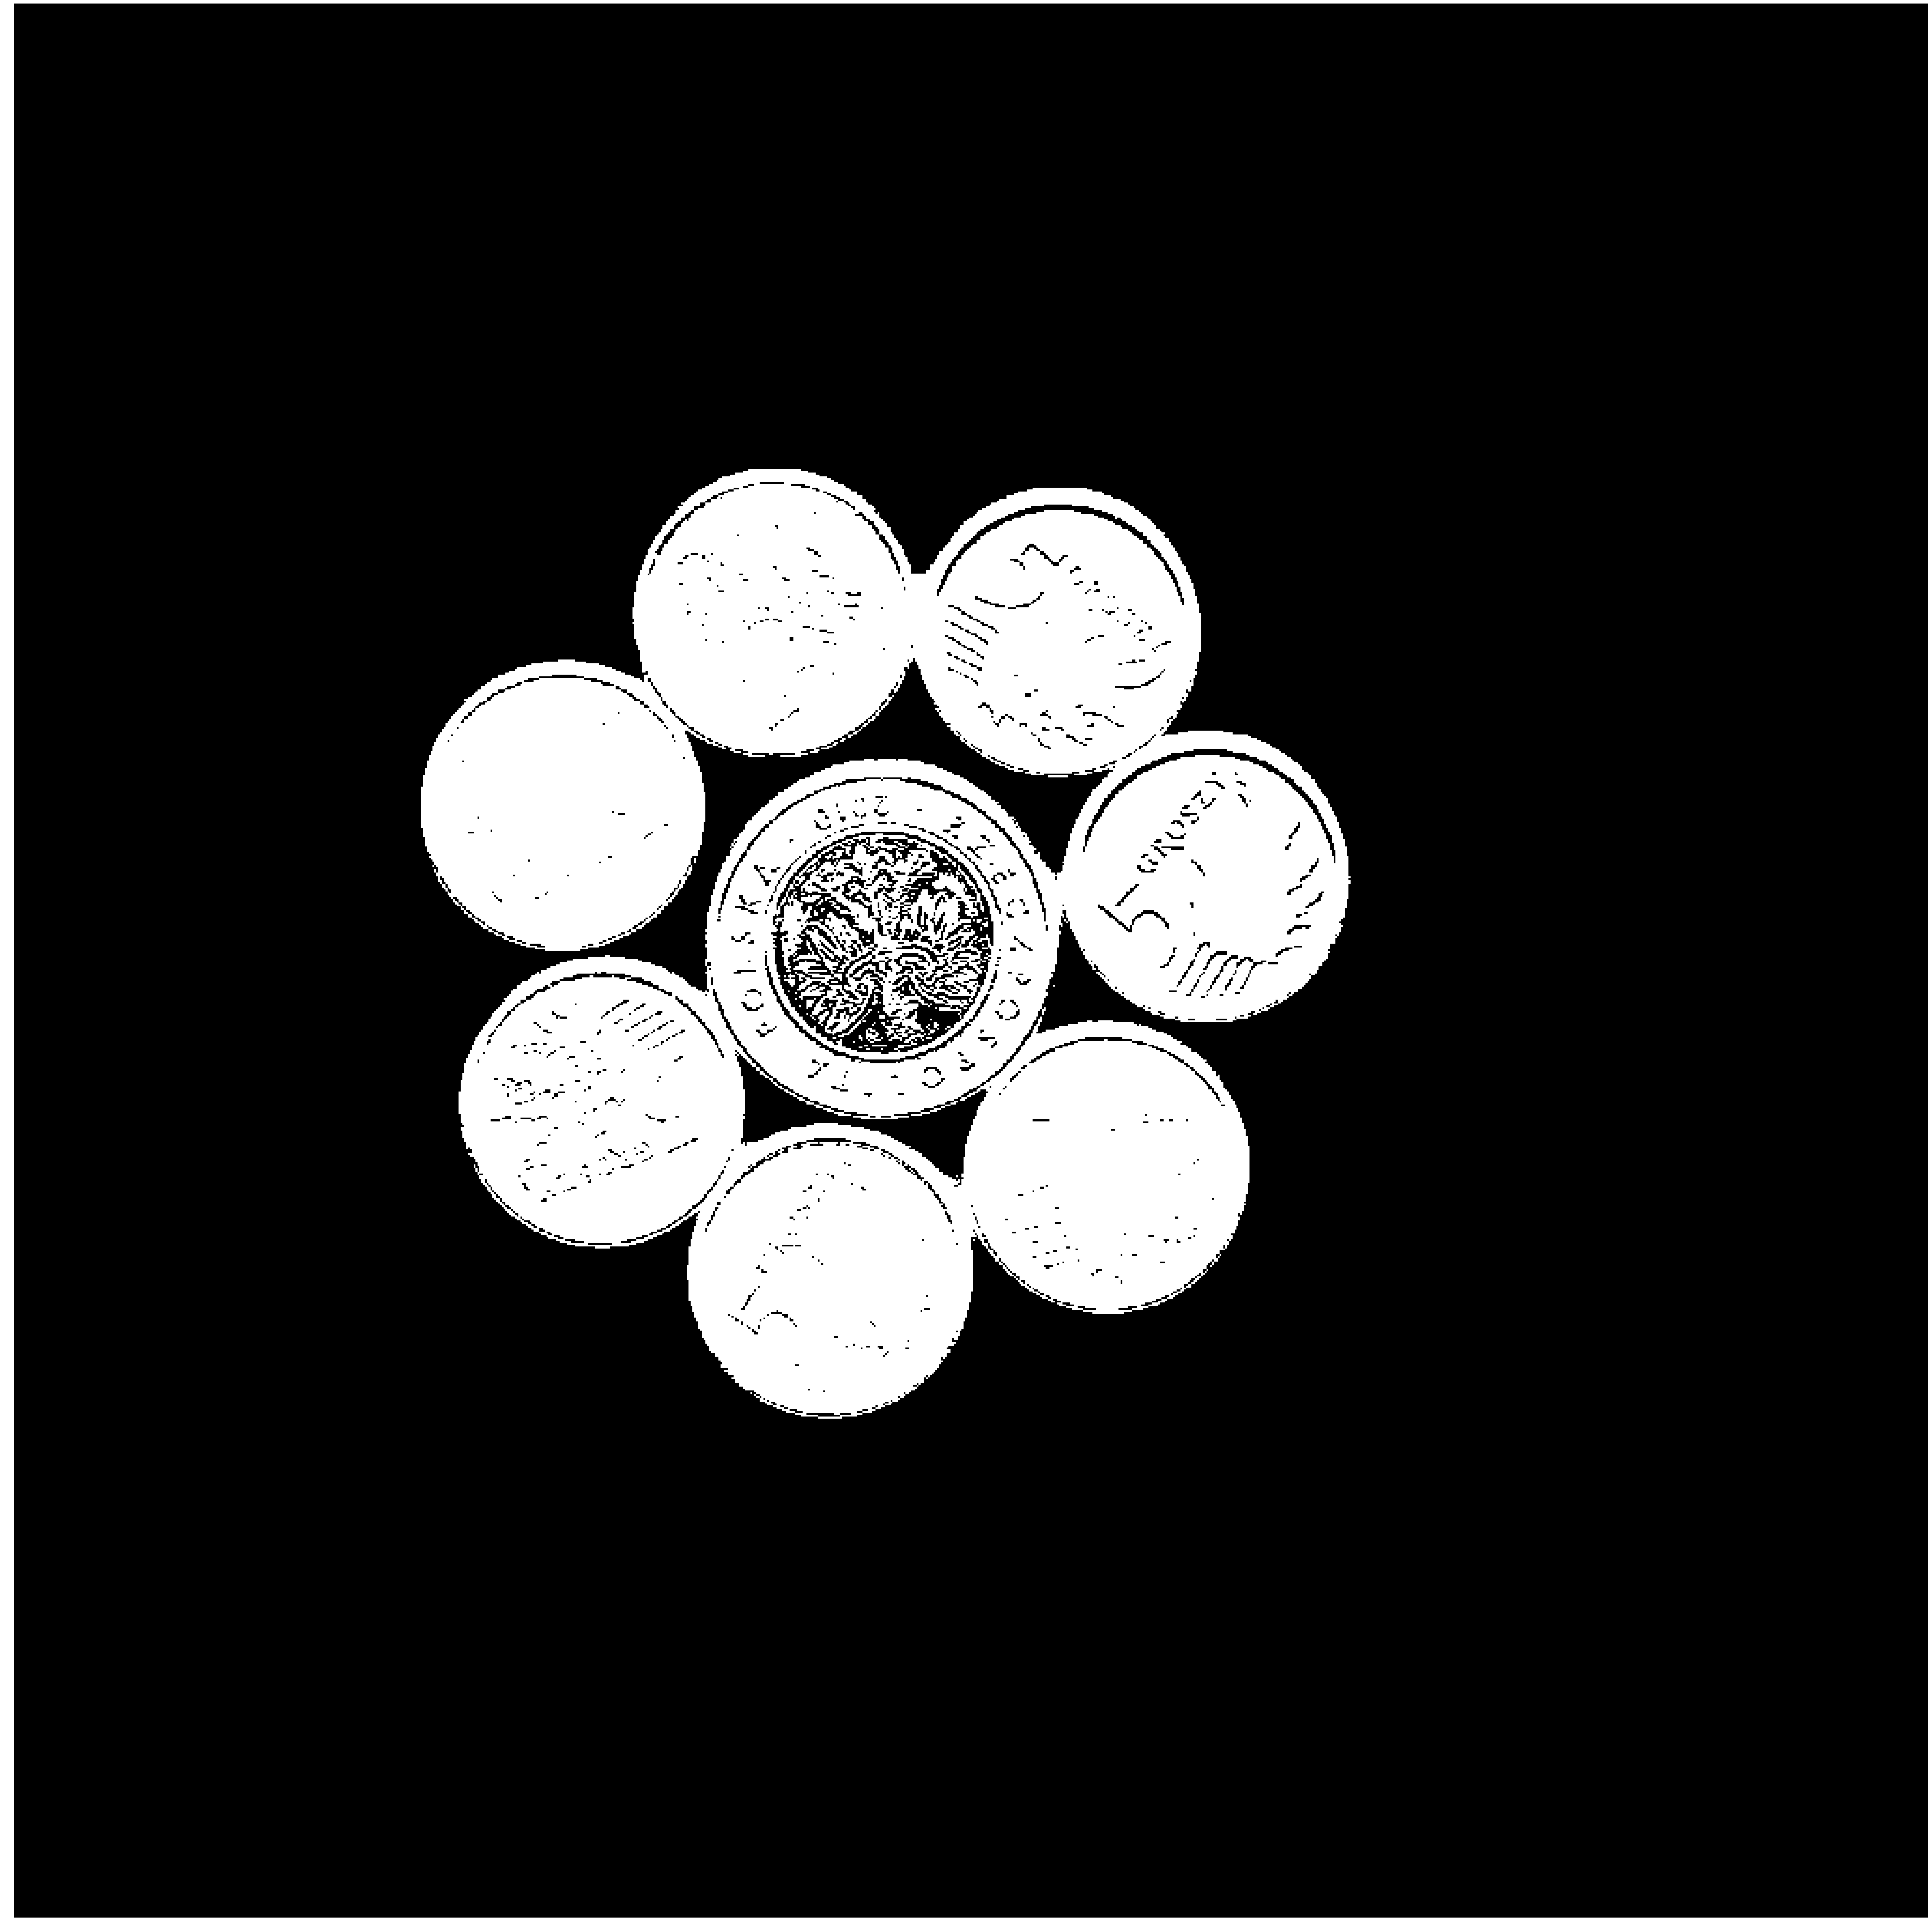

0


In [10]:
image_byte = img_as_ubyte(image_gray)
th, image_byte = cv2.threshold(image_byte, 170, 255, cv2.THRESH_BINARY_INV)
showImage(image_byte)
print(image_byte[1][1])

/anaconda3/lib/python3.7/site-packages/skimage/morphology/misc.py:203: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)


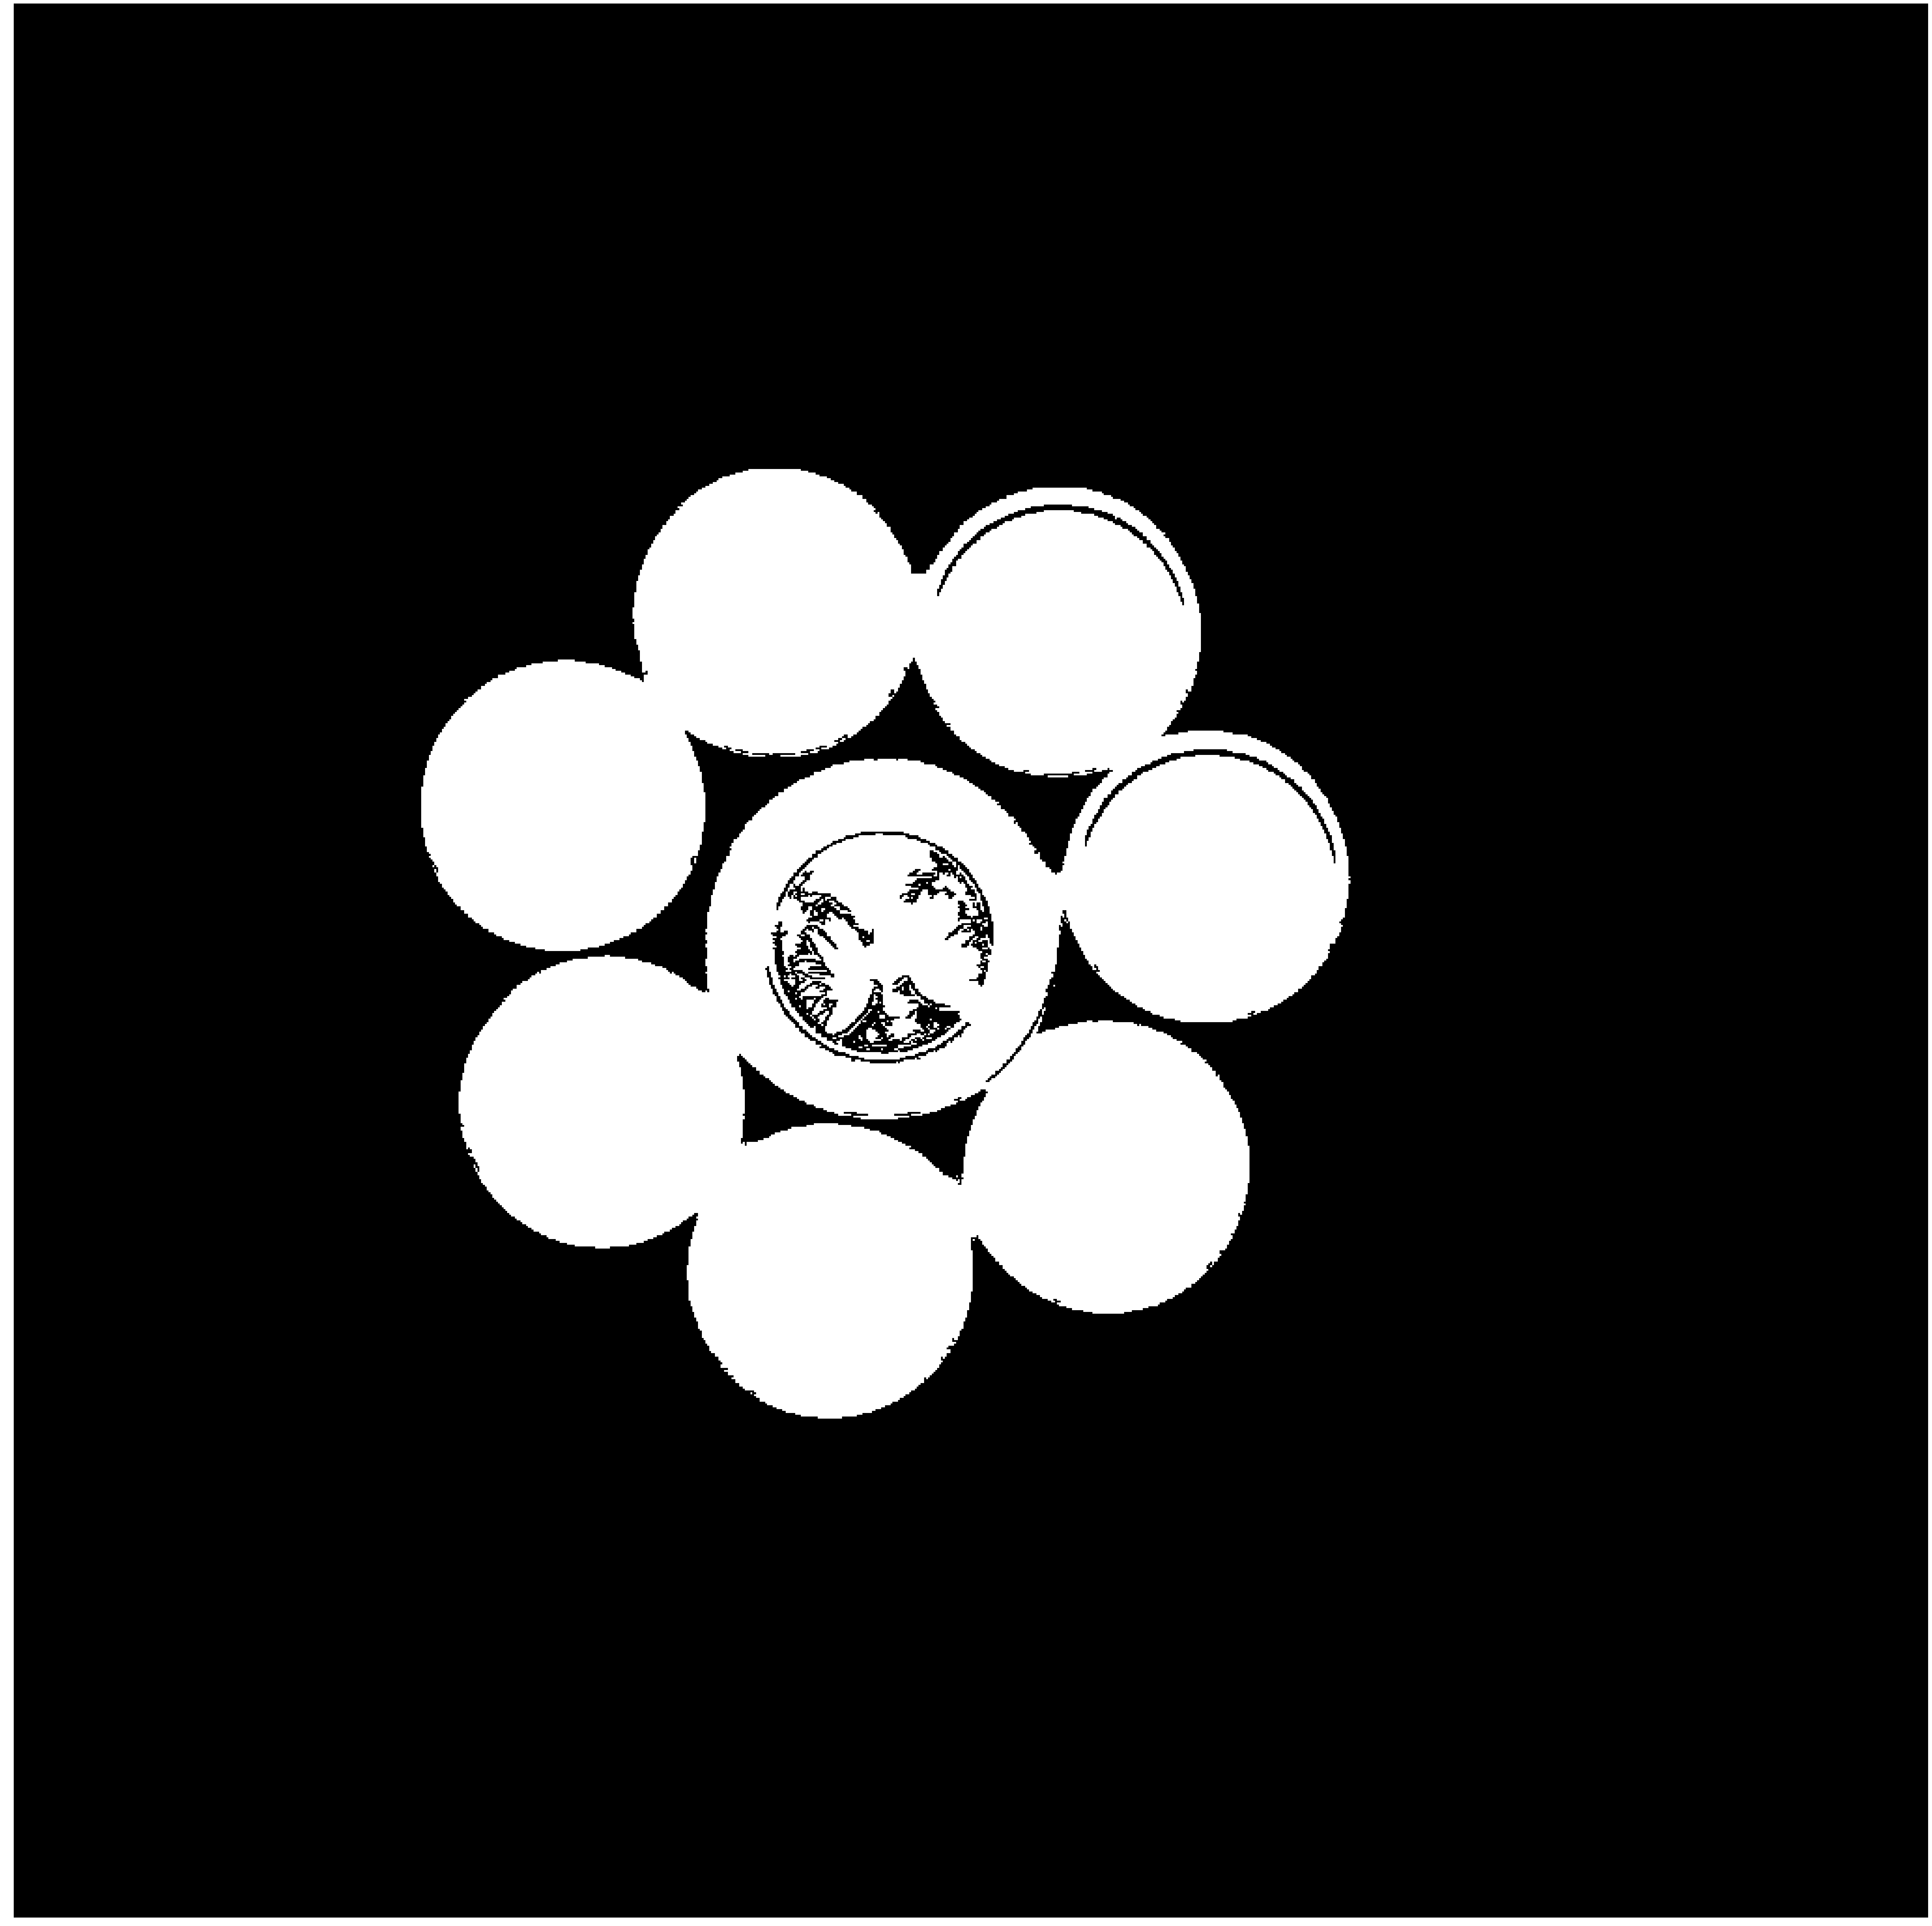

In [11]:
# dt = cv2.distanceTransform(coins_cleand_holes, distanceType=cv2.DIST_L2, maskSize=3)
# ret, coins_cleand_holes = cv2.threshold(dt,0.5*dt.max(),255,0)
import cv2
import numpy as np

kernel = np.ones((8,8),np.uint8)
coins_cleand_holes = cv2.erode(image_byte, kernel=kernel, iterations=5)
coins_cleand_holes = morphology.remove_small_holes(image_byte, 255) 


showImage(coins_cleand_holes)
# # print(coins_cleand_holes[1][1])

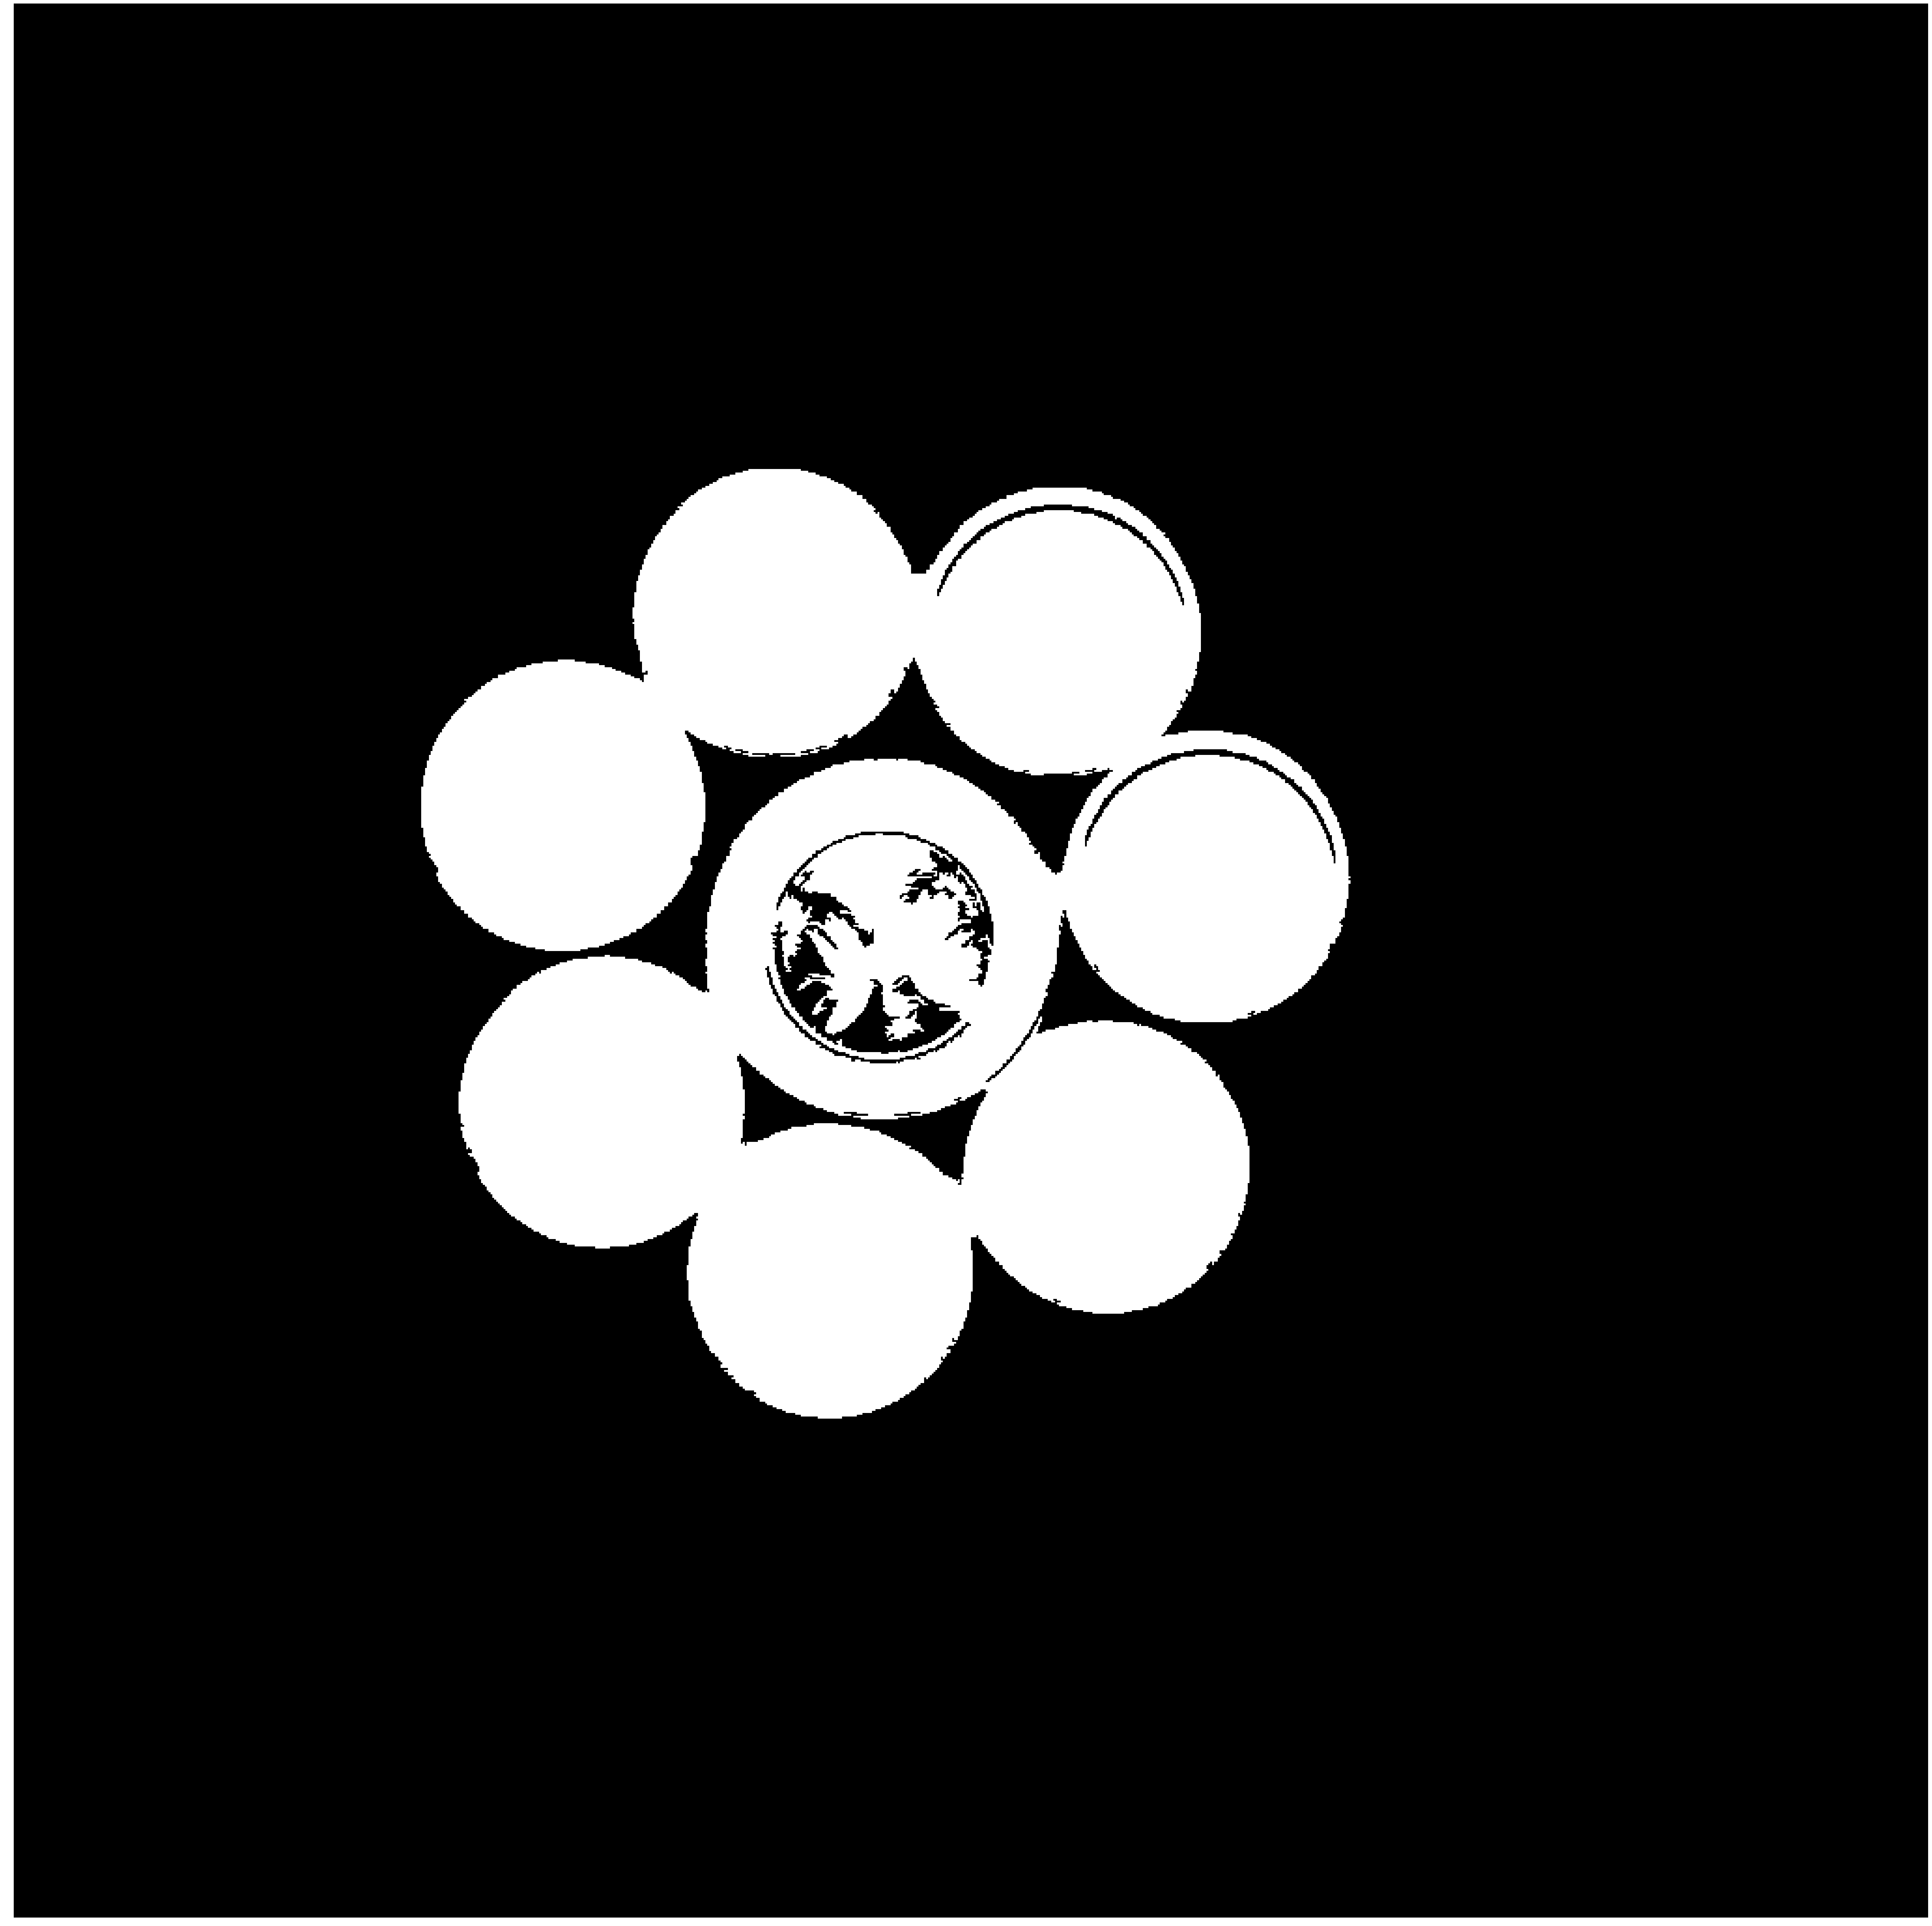

In [102]:
# coins_cleand = morphology.remove_small_objects(coins_cleand_holes, 128)
# showImage(coins_cleand)
# # print(coins_cleand)


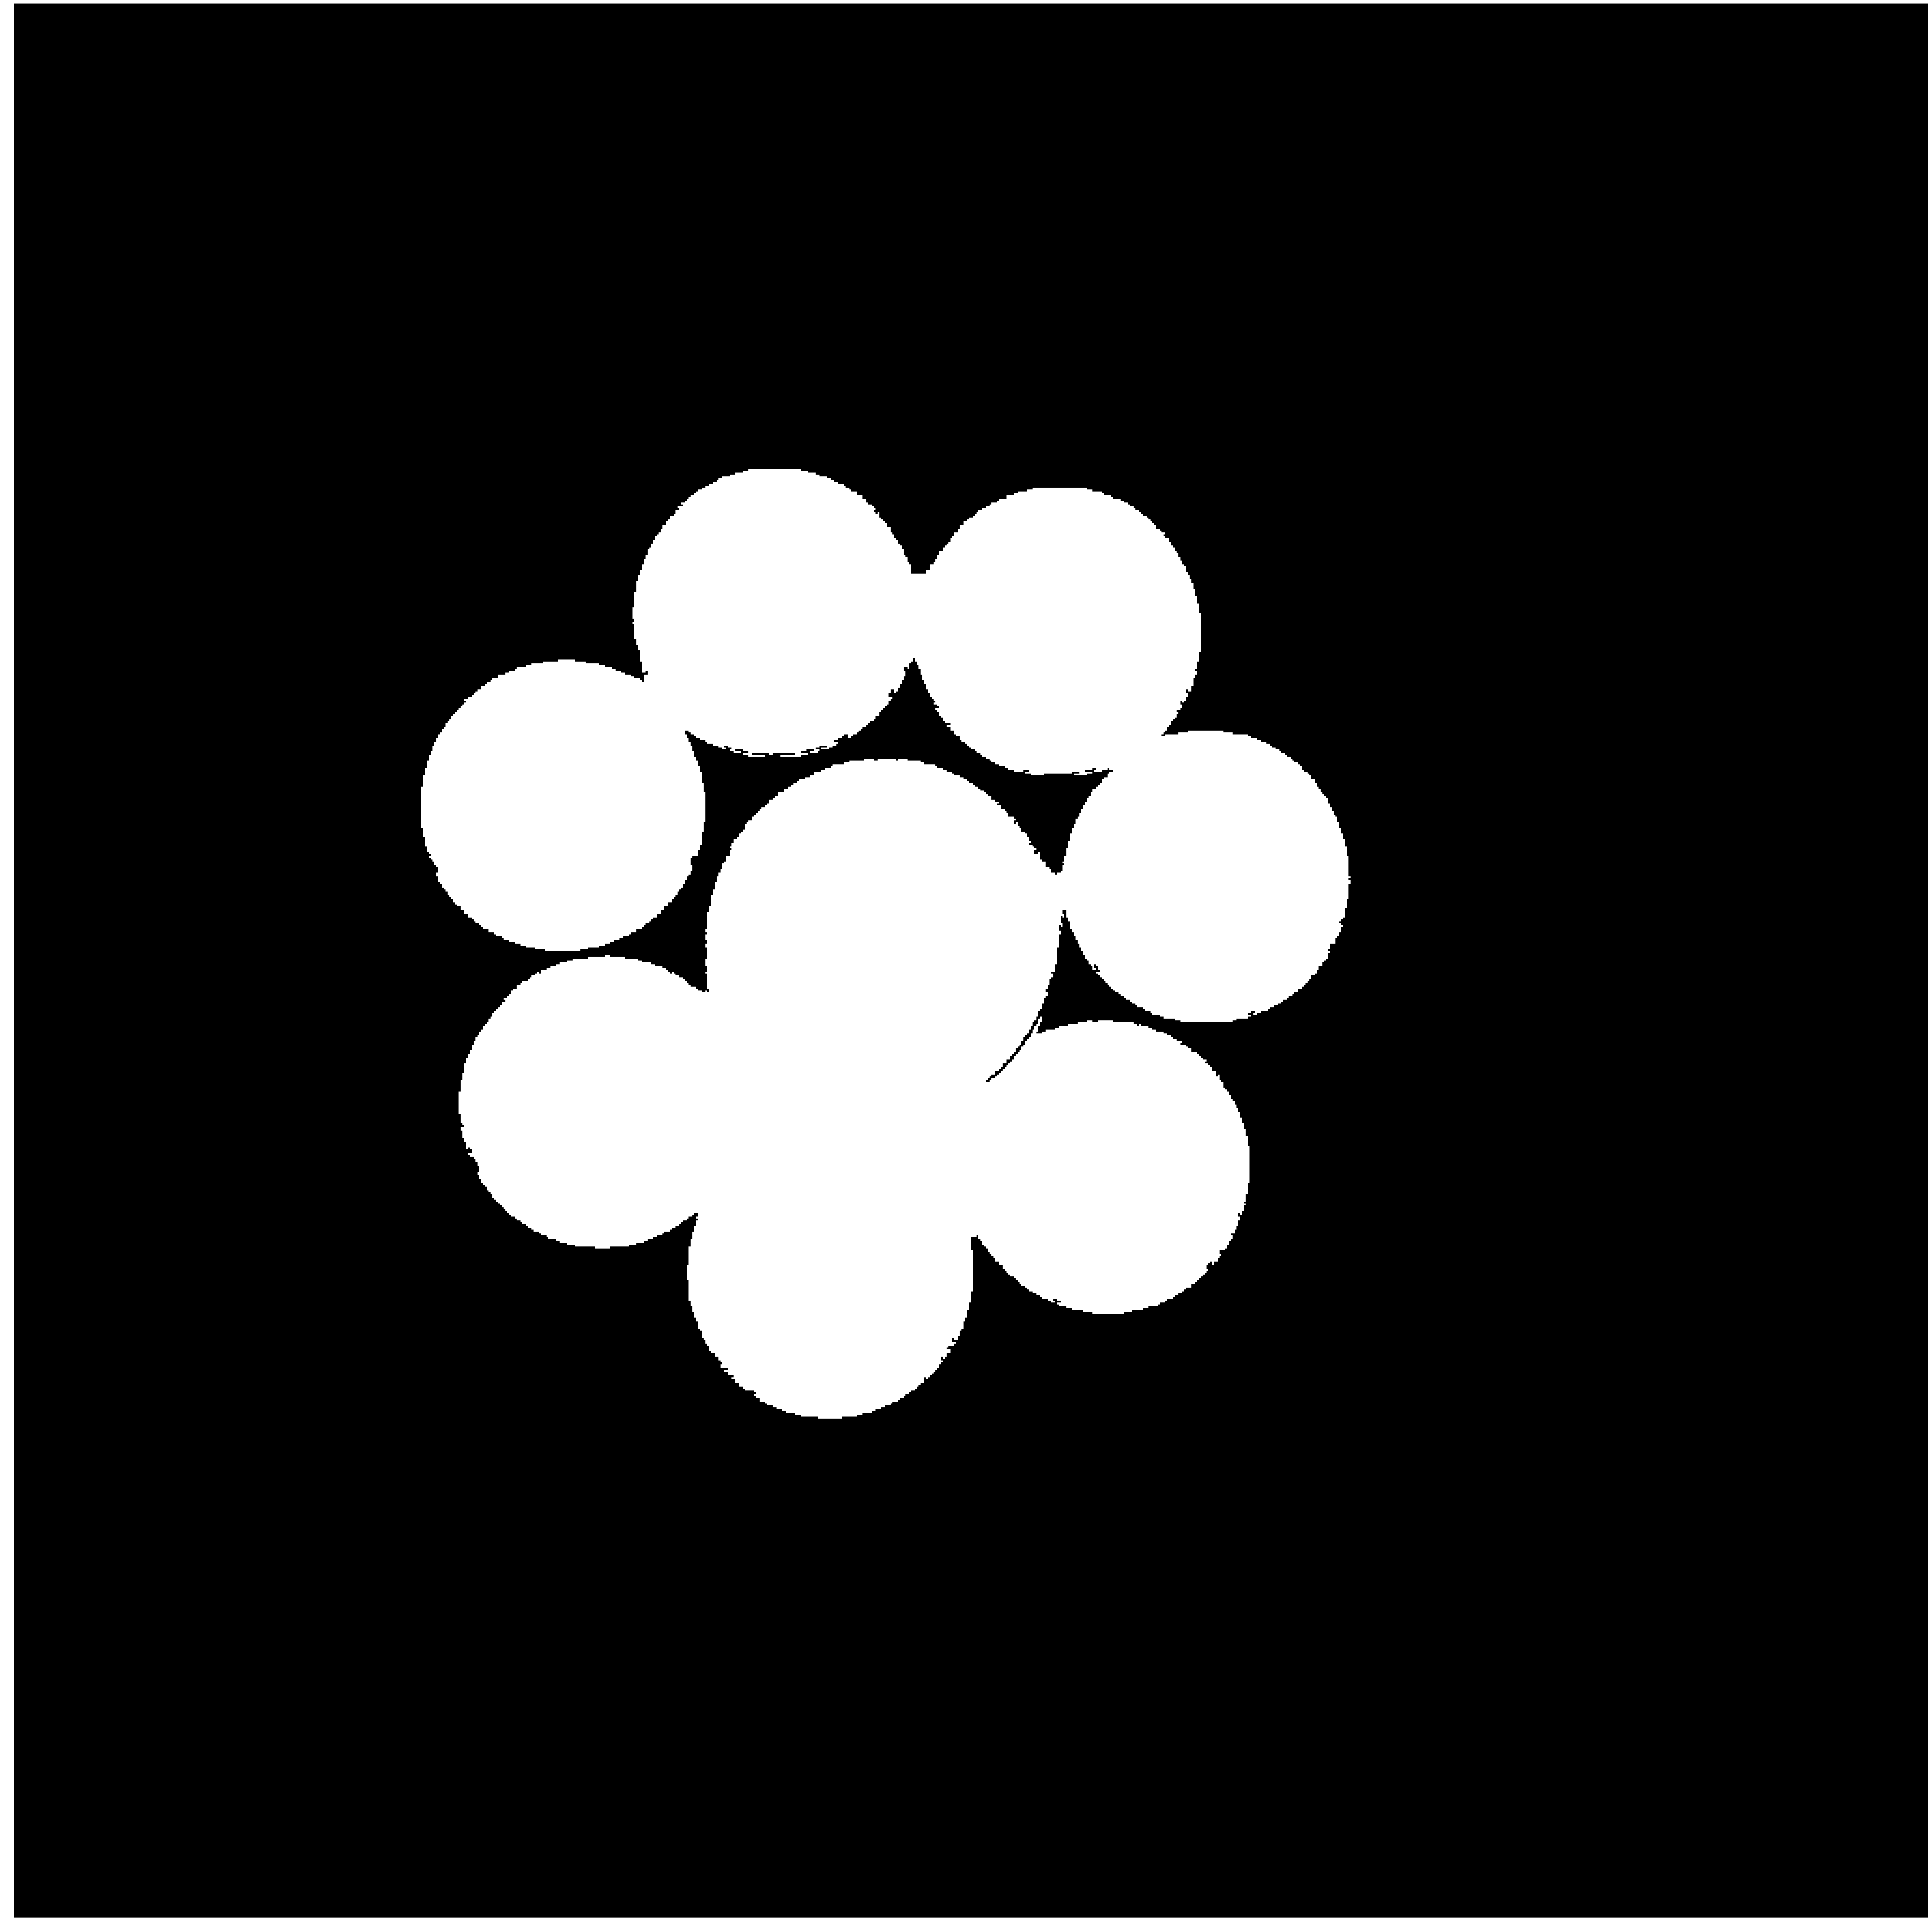

False


In [95]:
# fill_coins = ndi.binary_fill_holes(coins_cleand)
# fill_coins = morphology.remove_small_objects(fill_coins, 256)



# showImage(fill_coins)
# if fill_coins[1][1] == 0:
#     print(fill_coins[1][1])

In [96]:
# canny = feature.canny(coins_cleand, sigma=2)
# showImage(canny)

In [97]:

def split(im, index, size_x, size_y, start_x=0, start_y=0, place=1):
  
    status = 1
    tab_index = []
    
    for y in range(start_y, size_y):
        for x in range(start_x, size_x): 
            if im[start_y][start_x] != im[y][x]:
                status = 0
           
            if im[y][x] == im[y][x-1] and x > 0 and x == start_x:
                if index[y][x-1] > 0:
                    tab_index.append(index[y][x-1])
                    
            if im[y][x] == im[y-1][x] and y > 0 and y == start_y:
                if index[y-1][x] > 0:
                    tab_index.append(index[y-1][x])


    if status == 1:
        
        tab_index = list(set(tab_index))
        tab_index.sort()
        
        now = place
        if len(tab_index) > 0:
            now = tab_index[0]
        for y in range(start_y, size_y):
            for x in range(start_x, size_x):

                index[y][x] = now

        if len(tab_index) > 1:
            for i in range(len(tab_index)):
                if i > 0:
                    for y in range(len(im)):
                        for x in range(len(im[0])):

                            if index[y][x] == tab_index[i]:
                                index[y][x] = tab_index[0]
            
       

        place += 1   

    else:
        
        new_x = int(((size_x - start_x)/2) + start_x)
        new_y = int(((size_y - start_y)/2) + start_y)

        tab1, place = split(im, index, new_x, new_y, start_x, start_y, place)
        tab2, place = split(im, index, size_x, new_y, new_x, start_y, place)
        tab3, place = split(im, index, new_x, size_y, start_x, new_y, place)
        tab4, place = split(im, index, size_x, size_y, new_x, new_y, place)
        
        table = tab1 + tab2 + tab3 + tab4
        
    return index, place

def split_first(im, index, len_x, len_y):
    index, place = split(im, index, len_x, len_y)
    
    all_index = []
    
    for y in range(len_y):
        for x in range(len_x):
            all_index.append(index[y][x])
            
    all_index = list(set(all_index))
    
    
    len_index = len(all_index)
    for i in range(len_index):
        for y in range(len_y):
            for x in range(len_x):
                if index[y][x] == all_index[i]:
                    index[y][x] = i
    

    
    
    return index, len_index
im = fill_coins

len_y = len(im)
len_x = len(im[0])

index = [[0 for y in range(len_y)] for x in range(len_y)]
import time
t0 = time.time()
print("ok")
tab, place = split_first(im, index, len(im[1]), len(im))

print(place)








print("\nCzas trwania: ", time.time()-t0)

ok
2

Czas trwania:  66.13406300544739


In [98]:
simg = image
cash = 0
for i in range(18):
    j = 2+i
    k = 0
    for y in range(1024):
        for x in range(1024):
            if tab[y][x] == i:
                k += 1
                if i == 5:
                    simg[y][x] = [0, 254, 9]
    
    print("obiekt " + str(i) + " ma "+ str(k) +" pikseli")
    j+=20
print("na zdjeciu jest "+str(cash/100) +" zł")
    

        

obiekt 0 ma 886097 pikseli
obiekt 1 ma 162479 pikseli
obiekt 2 ma 0 pikseli
obiekt 3 ma 0 pikseli
obiekt 4 ma 0 pikseli
obiekt 5 ma 0 pikseli
obiekt 6 ma 0 pikseli
na zdjeciu jest 0.0 zł


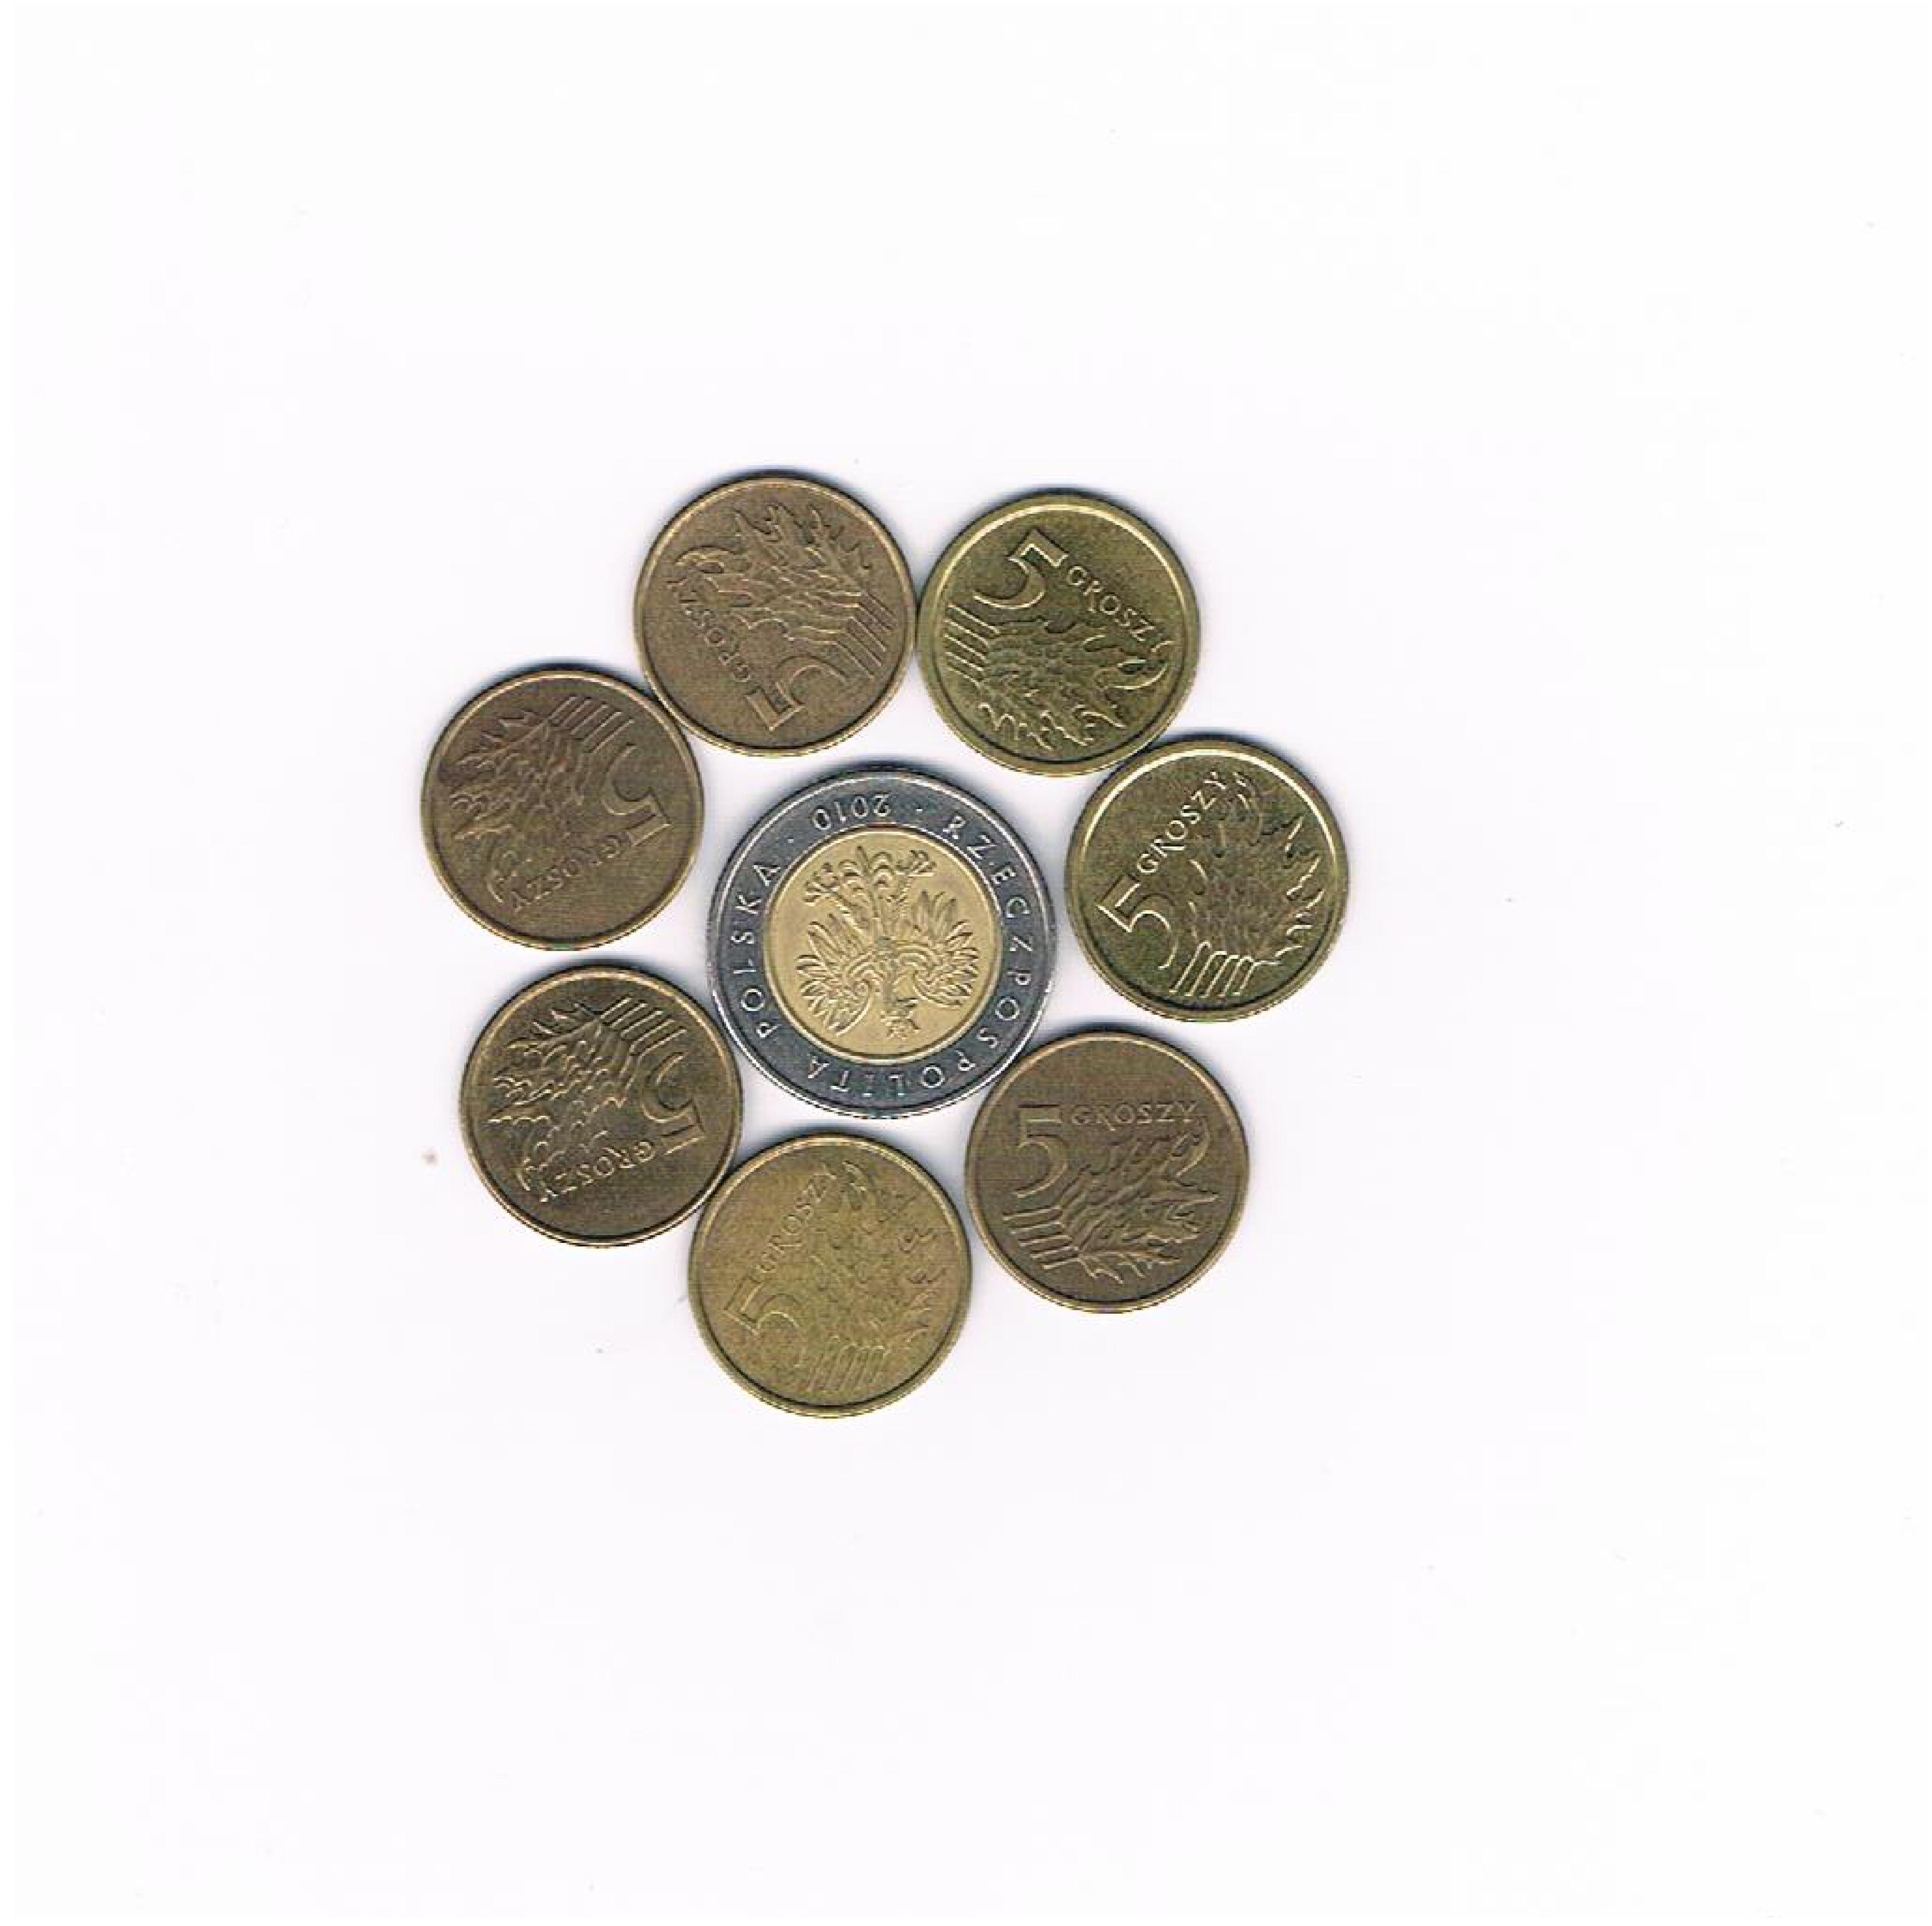

In [99]:
showImage(simg)